Dataset Loaded: 1794 samples, 1 features.
Number of clients: 5
Epoch 1/50 - Train Loss: 37.2149, Val Loss: 35.6000
Epoch 2/50 - Train Loss: 34.6404, Val Loss: 35.5712
Epoch 3/50 - Train Loss: 34.6336, Val Loss: 35.5627
Epoch 4/50 - Train Loss: 34.6184, Val Loss: 35.5761
Epoch 5/50 - Train Loss: 34.6336, Val Loss: 35.5709
Epoch 6/50 - Train Loss: 34.6210, Val Loss: 35.5774
Epoch 7/50 - Train Loss: 34.6162, Val Loss: 35.5581
Epoch 8/50 - Train Loss: 34.6399, Val Loss: 35.5654
Epoch 9/50 - Train Loss: 34.6219, Val Loss: 35.5565
Epoch 10/50 - Train Loss: 34.6378, Val Loss: 35.5526
Epoch 11/50 - Train Loss: 34.6163, Val Loss: 35.5609
Epoch 12/50 - Train Loss: 34.6211, Val Loss: 35.5662
Epoch 13/50 - Train Loss: 34.6162, Val Loss: 35.5574
Epoch 14/50 - Train Loss: 34.6103, Val Loss: 35.5619
Epoch 15/50 - Train Loss: 34.6247, Val Loss: 35.5545
Epoch 16/50 - Train Loss: 34.6149, Val Loss: 35.5555
Epoch 17/50 - Train Loss: 34.6214, Val Loss: 35.5512
Epoch 18/50 - Train Loss: 34.6263, Val Loss: 

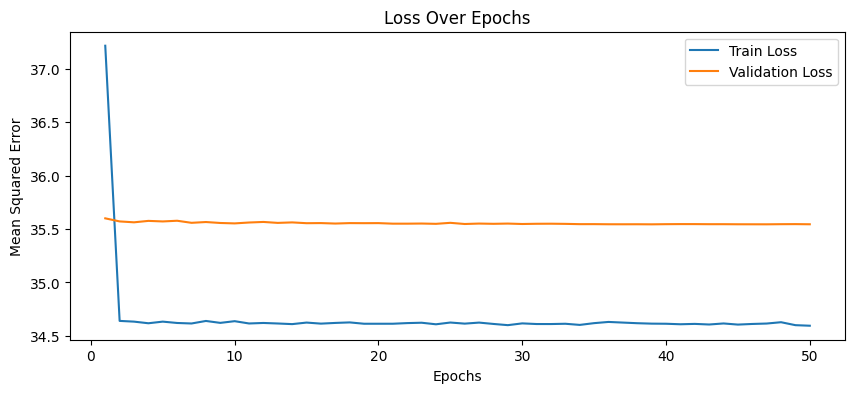

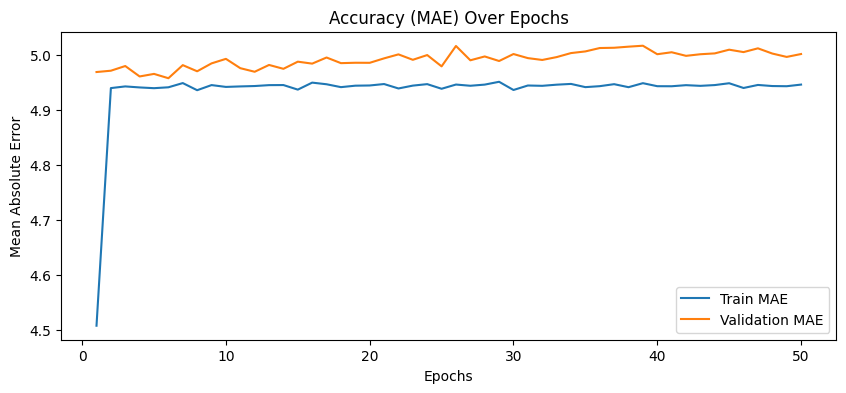

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset safely
def load_data(csv_file):
    data = pd.read_csv(csv_file)

    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.shape[1] < 1:
        raise ValueError("Dataset must have at least 1 numeric column")

    if numeric_data.shape[1] < 4:
        X = numeric_data.iloc[:, :-1].values.astype(np.float32)  # inputs
        y = numeric_data.iloc[:, -1:].values.astype(np.float32)  # last column as output
    else:
        X = numeric_data.iloc[:, :-3].values.astype(np.float32)
        y = numeric_data.iloc[:, -3:].values.astype(np.float32)

    return X, y

# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                     shape=(self.units, int(input_shape[-1])),
                                     initializer='uniform',
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_centers = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(expanded_inputs - expanded_centers), axis=-1)
        return tf.exp(-self.gamma * distances)

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Score computation
        score = self.V(tf.nn.tanh(self.W(inputs)))

        # Attention weights
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context vector
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

# Flexible model for any dataset
def create_model(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))

    if input_dim > 2:
        x = tf.keras.layers.Reshape((input_dim, 1))(inputs)
        x = tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu', padding="same")(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
        x = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', padding="same")(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)

        # Add attention layer after Conv layers
        x = AttentionLayer(64)(x)
        x = tf.keras.layers.Flatten()(x)
    else:
        x = inputs  # No Conv for small input

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # RBF layer
    x = RBFLayer(units=20, gamma=0.5)(x)

    x = tf.keras.layers.Dense(30, activation='relu')(x)
    x = tf.keras.layers.Dense(15, activation='relu')(x)

    output_units = 3 if input_dim > 3 else 1
    outputs = tf.keras.layers.Dense(output_units)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

    return model

# Load Data
csv_file = "/content/driving_log.csv"
X_train, y_train = load_data(csv_file)

print(f"Dataset Loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features.")

# Create client data for federated learning
num_clients = min(5, max(1, X_train.shape[0] // 10))
samples_per_client = X_train.shape[0] // num_clients

client_data = {}
for i in range(num_clients):
    start_idx = i * samples_per_client
    end_idx = (i + 1) * samples_per_client if i != num_clients - 1 else len(X_train)
    X_client = X_train[start_idx:end_idx]
    y_client = y_train[start_idx:end_idx]

    if X_client.shape[0] > 1:
        client_data[f'car_{i}'] = (X_client, y_client)

print(f"Number of clients: {len(client_data)}")

# Initialize model
input_dim = X_train.shape[1]
global_model = create_model(input_dim)

# Training settings
num_epochs = 50
batch_size = 10
train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []

# Federated Training
for epoch in range(num_epochs):
    client_losses, client_accuracies = [], []

    for client in client_data:
        X_client, y_client = client_data[client]
        if len(X_client) < 2:
            continue
        history = global_model.fit(
            X_client, y_client, epochs=1, batch_size=batch_size, verbose=0, validation_split=0.2
        )
        client_losses.append(history.history['loss'][0])
        client_accuracies.append(history.history['mae'][0])

    if not client_losses:
        continue

    avg_loss = np.mean(client_losses)
    avg_acc = np.mean(client_accuracies)

    X_test, y_test = load_data(csv_file)
    test_loss, test_acc = global_model.evaluate(X_test, y_test, verbose=0)

    train_loss_history.append(avg_loss)
    train_acc_history.append(avg_acc)
    val_loss_history.append(test_loss)
    val_acc_history.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Val Loss: {test_loss:.4f}")

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label="Train Loss")
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# Plot Accuracy (MAE) Curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_acc_history)+1), train_acc_history, label="Train MAE")
plt.plot(range(1, len(val_acc_history)+1), val_acc_history, label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Accuracy (MAE) Over Epochs")
plt.legend()
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5367.5757 - mae: 73.2266 - val_loss: 5343.3525 - val_mae: 73.0612
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5314.3560 - mae: 72.8621 - val_loss: 5157.1436 - val_mae: 71.7742
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4990.2051 - mae: 70.5829 - val_loss: 4085.2061 - val_mae: 63.8133
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3453.9688 - mae: 58.2883 - val_loss: 1218.0369 - val_mae: 33.7023
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 724.2669 - mae: 24.2793 - val_loss: 135.3981 - val_mae: 9.0880
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 130.1516 - mae: 8.6258 - val_loss: 99.2224 - val_mae: 7.3042
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 103.0547 - mae: 7.4427 - val_loss: 81.9861 - val_mae: 6.6981
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 77.7779 - mae: 6.4092 - val_loss: 68.7690 - val_mae: 6.0075
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69.0425 - mae: 5.9587 - val_loss: 58.0911 - val_mae: 5.6013
90/90 

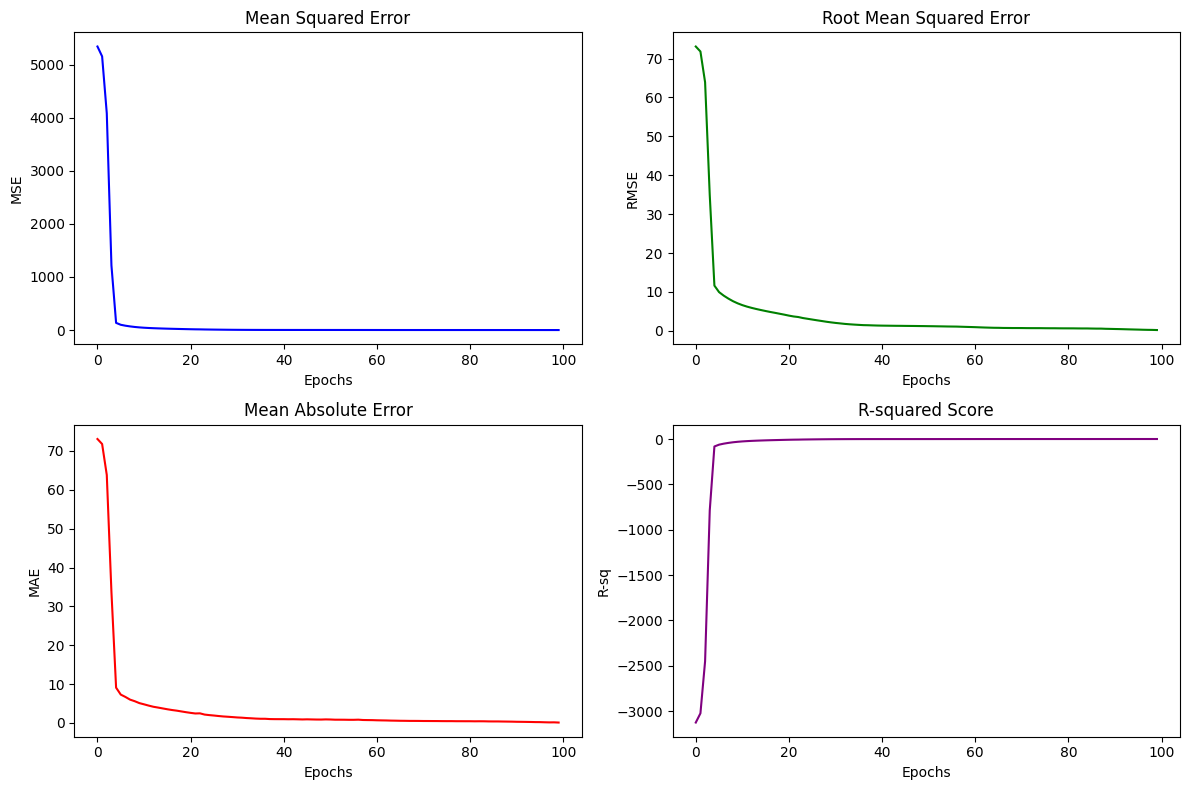

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


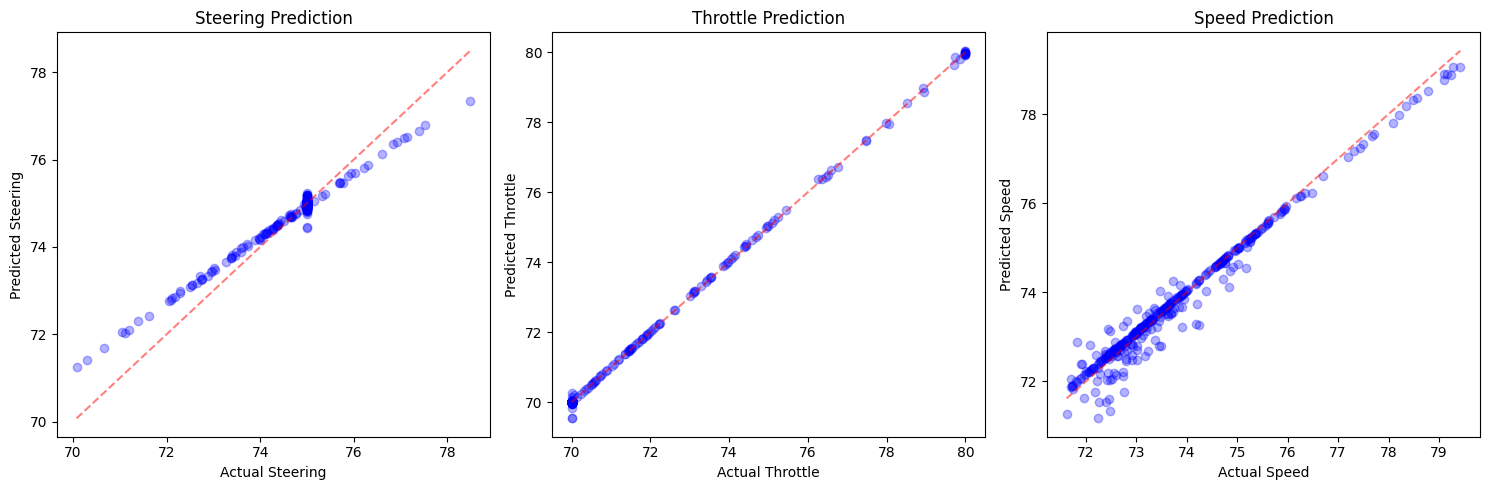

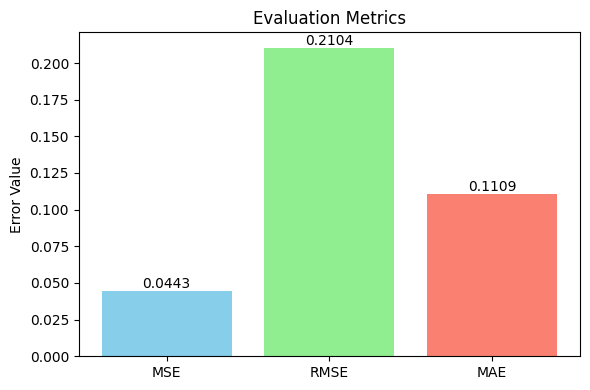


Evaluation Metrics:
MSE: 0.0443
RMSE: 0.2104
MAE: 0.1109
R-squared: 0.9662


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset from CSV file
def load_data(csv_file):
    # Read CSV without header
    data = pd.read_csv(csv_file, header=None)

    # Assign column names for clarity
    data.columns = ['center_img', 'left_img', 'right_img', 'steering', 'throttle', 'brake', 'speed']

    # Extract numerical features: steering, throttle, brake, speed
    features = data[['steering', 'throttle', 'brake', 'speed']].values
    # Extract targets: steering, throttle, speed
    targets = data[['steering', 'throttle', 'speed']].values

    # Handle any NaN or invalid values
    features = np.nan_to_num(features, nan=0.0)
    targets = np.nan_to_num(targets, nan=0.0)

    return features, targets


def normalize_data(features, targets):
    feature_scaler = MinMaxScaler()
    features_scaled = feature_scaler.fit_transform(features)


    target_scaler = MinMaxScaler()
    targets_scaled = target_scaler.fit_transform(targets)

    targets_mapped = targets_scaled * (80 - 70) + 70

    return features_scaled, targets_mapped, feature_scaler, target_scaler

# Define dense neural network model with adjusted architecture
def create_dense_model(input_shape=(4,)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3)  # 3 outputs: steering, throttle, speed
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                 loss='mse',
                 metrics=['mae'])
    return model

# Load training data from CSV
csv_file = "/content/driving_log.csv"
X, y = load_data(csv_file)

# Normalize data and scale targets to 70-80 range
X_scaled, y_mapped, feature_scaler, target_scaler = normalize_data(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_mapped, test_size=0.2, random_state=42)

# Initialize dense model
model = create_dense_model()

# Training parameters
num_epochs = 100  # Increased epochs for better convergence
batch_size = 16   # Smaller batch size for finer updates

# Lists to store metrics for each epoch
mse_history = []
rmse_history = []
mae_history = []
r2_history = []

# Custom training loop to calculate metrics per epoch
for epoch in range(num_epochs):
    # Train for one epoch
    history = model.fit(X_train, y_train,
                        epochs=1,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        verbose=1)

    # Predict on validation set
    y_pred_epoch = model.predict(X_test, verbose=0)

    # Calculate metrics for this epoch
    mse_epoch = mean_squared_error(y_test, y_pred_epoch)
    rmse_epoch = np.sqrt(mse_epoch)
    mae_epoch = mean_absolute_error(y_test, y_pred_epoch)
    r2_epoch = r2_score(y_test, y_pred_epoch)

    # Append to history lists
    mse_history.append(mse_epoch)
    rmse_history.append(rmse_epoch)
    mae_history.append(mae_epoch)
    r2_history.append(r2_epoch)

# Plot training history metrics over epochs
plt.figure(figsize=(12, 8))

# Mean Squared Error
plt.subplot(2, 2, 1)
plt.plot(mse_history, color='blue')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')

# Root Mean Squared Error
plt.subplot(2, 2, 2)
plt.plot(rmse_history, color='green')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')

# Mean Absolute Error
plt.subplot(2, 2, 3)
plt.plot(mae_history, color='red')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')

# R-squared Score
plt.subplot(2, 2, 4)
plt.plot(r2_history, color='purple')
plt.title('R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('R-sq')

plt.tight_layout()
plt.show()

# Final evaluation on test set
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot predicted vs actual for each output (scatter plots)
output_names = ['Steering', 'Throttle', 'Speed']
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.3, color='blue')
    plt.plot([min(y_test[:, i]), max(y_test[:, i])],
             [min(y_test[:, i]), max(y_test[:, i])],
             'r--', alpha=0.5)
    plt.xlabel(f'Actual {output_names[i]}')
    plt.ylabel(f'Predicted {output_names[i]}')
    plt.title(f'{output_names[i]} Prediction')

plt.tight_layout()
plt.show()

# Plot evaluation metrics
metrics = ['MSE', 'RMSE', 'MAE']
values = [mse, rmse, mae]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Evaluation Metrics')
plt.ylabel('Error Value')

# Annotate bars with metric values
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

   hard_left       0.04      0.05      0.04        20
  hard_right       0.12      0.14      0.13         7
        left       0.08      0.07      0.08        41
       right       0.18      0.18      0.18        11
    straight       0.88      0.87      0.87       460

    accuracy                           0.75       539
   macro avg       0.26      0.26      0.26       539
weighted avg       0.76      0.75      0.76       539



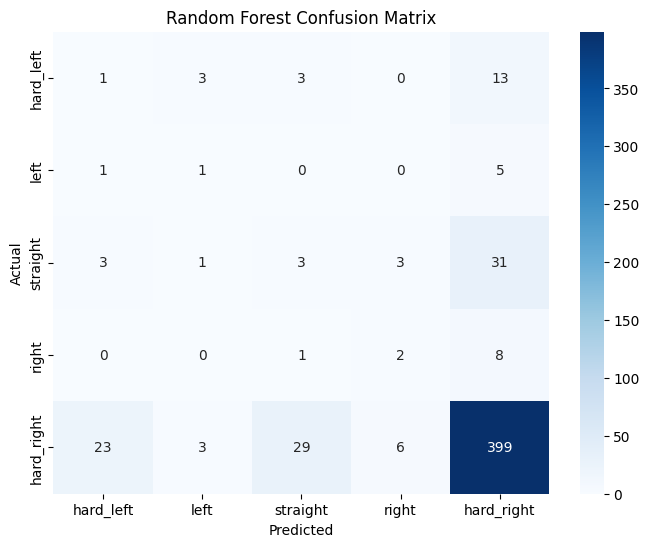


Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

   hard_left       0.03      0.05      0.04        20
  hard_right       0.12      0.14      0.13         7
        left       0.08      0.07      0.08        41
       right       0.12      0.18      0.14        11
    straight       0.87      0.85      0.86       460

    accuracy                           0.73       539
   macro avg       0.25      0.26      0.25       539
weighted avg       0.76      0.73      0.74       539



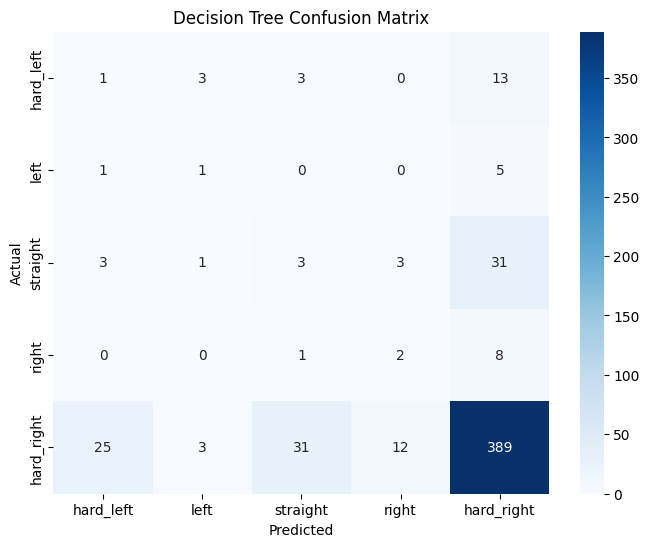


Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


SVM Classification Report:
              precision    recall  f1-score   support

   hard_left       0.00      0.00      0.00        20
  hard_right       0.00      0.00      0.00         7
        left       0.00      0.00      0.00        41
       right       0.00      0.00      0.00        11
    straight       0.85      1.00      0.92       460

    accuracy                           0.85       539
   macro avg       0.17      0.20      0.18       539
weighted avg       0.73      0.85      0.79       539



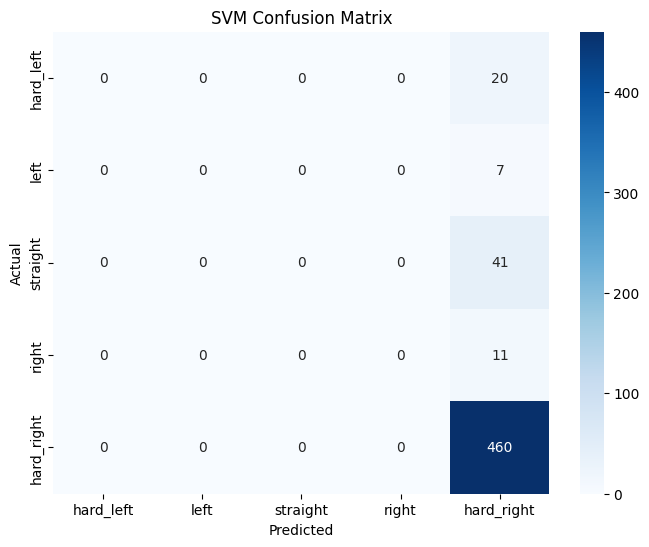


Training Neural Network...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bei


Neural Network Classification Report:
              precision    recall  f1-score   support

   hard_left       0.00      0.00      0.00        20
  hard_right       0.00      0.00      0.00         7
        left       0.00      0.00      0.00        41
       right       0.00      0.00      0.00        11
    straight       0.85      1.00      0.92       460

    accuracy                           0.85       539
   macro avg       0.17      0.20      0.18       539
weighted avg       0.73      0.85      0.79       539



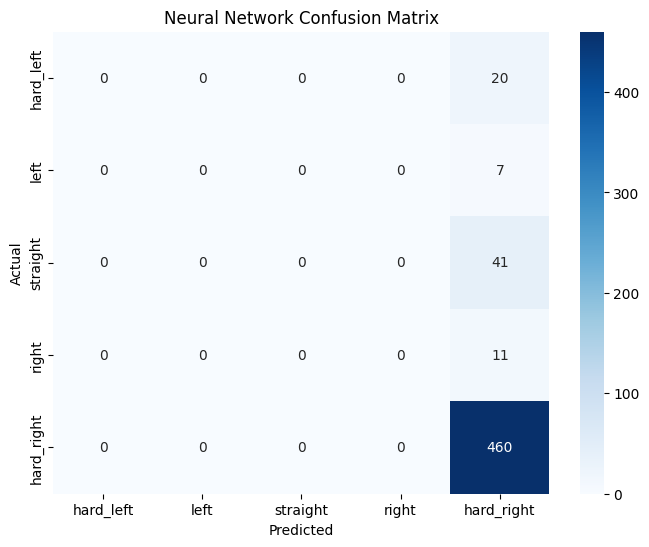


Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   hard_left       0.00      0.00      0.00        20
  hard_right       0.00      0.00      0.00         7
        left       0.00      0.00      0.00        41
       right       0.00      0.00      0.00        11
    straight       0.85      1.00      0.92       460

    accuracy                           0.85       539
   macro avg       0.17      0.20      0.18       539
weighted avg       0.73      0.85      0.79       539



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: 

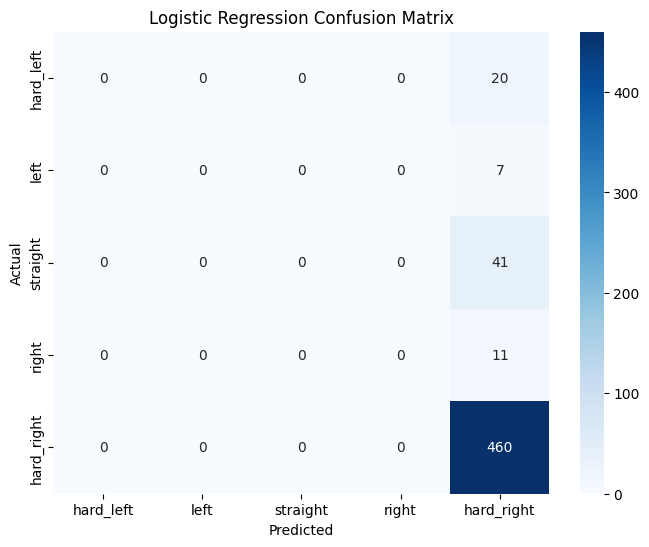


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.753247   0.759751  0.753247  0.756408
1        Decision Tree  0.734694   0.755628  0.734694  0.744768
2                  SVM  0.853432   0.728347  0.853432  0.785944
3       Neural Network  0.853432   0.728347  0.853432  0.785944
4  Logistic Regression  0.853432   0.728347  0.853432  0.785944


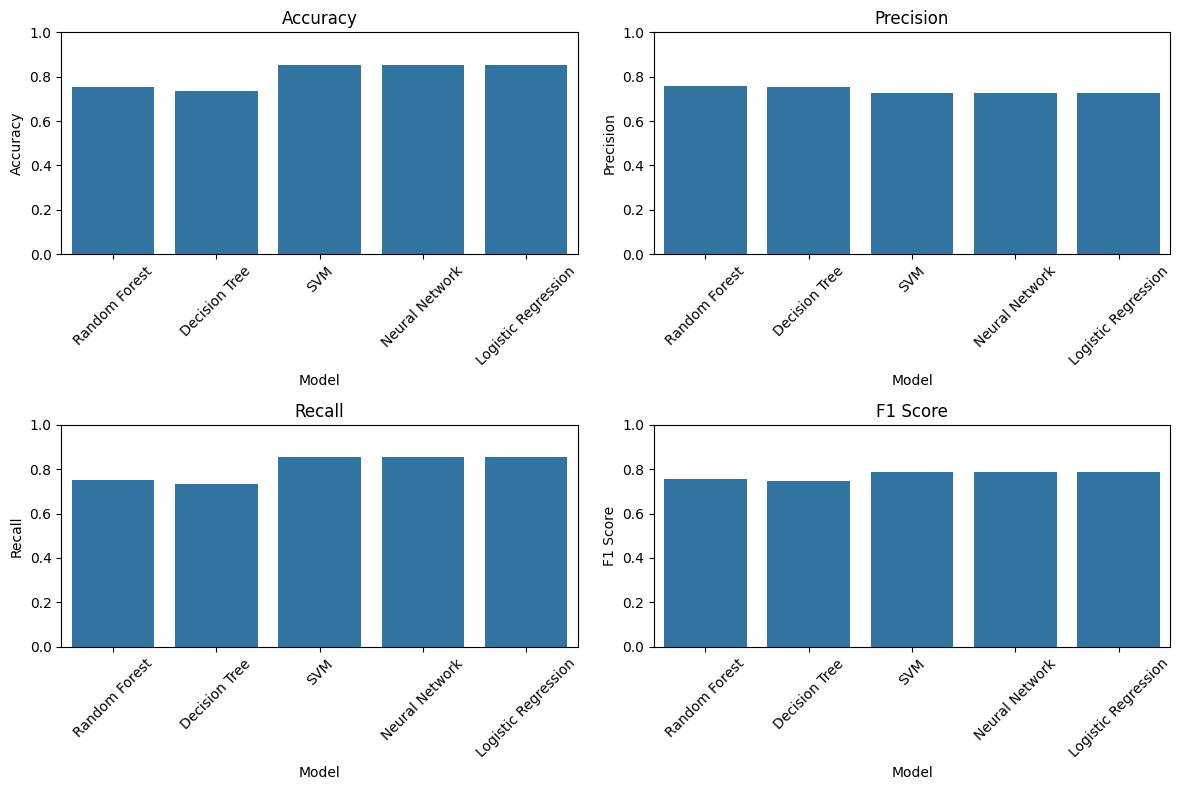


Performing hyperparameter tuning for the best model...

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.8471

Best Model Classification Report:
              precision    recall  f1-score   support

   hard_left       0.00      0.00      0.00        20
  hard_right       0.00      0.00      0.00         7
        left       0.00      0.00      0.00        41
       right       0.00      0.00      0.00        11
    straight       0.86      1.00      0.92       460

    accuracy                           0.85       539
   macro avg       0.17      0.20      0.18       539
weighted avg       0.73      0.85      0.79       539



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


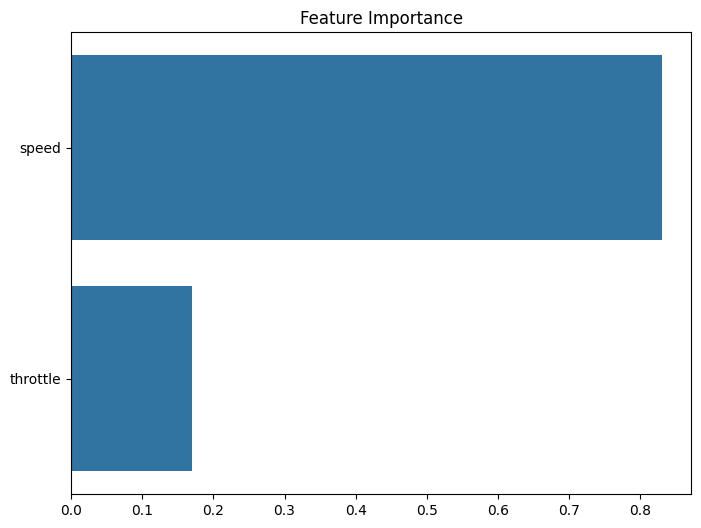

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the labels globally
STEERING_LABELS = ['hard_left', 'left', 'straight', 'right', 'hard_right']

# Load the dataset
def load_data(filepath):
    df = pd.read_csv(filepath, header=None)
    df.columns = ['center_img', 'left_img', 'right_img', 'steering', 'throttle', 'brake', 'speed']
    return df

# Preprocess the data
def preprocess_data(df):
    # Convert steering angles to discrete classes for classification
    bins = [-1.1, -0.5, -0.2, 0.2, 0.5, 1.1]
    df['steering_class'] = pd.cut(df['steering'], bins=bins, labels=STEERING_LABELS)

    # Drop rows with missing values
    df = df.dropna()

    # Feature selection - using speed and throttle as features
    X = df[['speed', 'throttle']]
    y = df['steering_class']

    return X, y

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': SVC(random_state=42),
        'Neural Network': MLPClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
    }

    results = []

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=STEERING_LABELS, yticklabels=STEERING_LABELS)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return pd.DataFrame(results)

# Plot metrics comparison
def plot_metrics_comparison(results_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.barplot(x='Model', y=metric, data=results_df)
        plt.title(metric)
        plt.xticks(rotation=45)
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Load and preprocess data
    df = load_data('driving_log.csv')
    X, y = preprocess_data(df)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train and evaluate models
    results_df = train_evaluate_models(X_train, X_test, y_train, y_test)

    # Display results
    print("\nModel Performance Comparison:")
    print(results_df)

    # Plot metrics comparison
    plot_metrics_comparison(results_df)

    # Hyperparameter tuning for the best model
    print("\nPerforming hyperparameter tuning for the best model...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Evaluate best model on test set
    y_pred = best_model.predict(X_test)
    print("\nBest Model Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot feature importance
    if hasattr(best_model, 'feature_importances_'):
        plt.figure(figsize=(8, 6))
        feature_importance = best_model.feature_importances_
        sns.barplot(x=feature_importance, y=['speed', 'throttle'])
        plt.title('Feature Importance')
        plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv('/content/driving_log.csv')

# Keep only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Assume the first numeric column is target
X = numeric_df.iloc[:, 1:]
y = numeric_df.iloc[:, 0]

# Check if the target is constant or mostly the same
y_unique = y.nunique()

# If not enough unique values for qcut, use cut instead
y_class = pd.cut(y, bins=4, labels=False)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8384
Precision: 0.8325
Recall: 0.8384
F1 Score: 0.8354
